1. Preprocesamiento de Datos
Incluye imputación de valores faltantes, codificación de variables categóricas y escalamiento de datos numéricos.

In [1]:
import pandas as pd
import numpy as np
from sklearn.impute import SimpleImputer
from sklearn.preprocessing import OneHotEncoder, StandardScaler
from sklearn.compose import ColumnTransformer
from sklearn.model_selection import train_test_split, cross_val_score

# Cargar datos
df = pd.read_csv('../data/dataset1.csv')  # Reemplaza con tu archivo


In [2]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1338 entries, 0 to 1337
Data columns (total 7 columns):
 #   Column    Non-Null Count  Dtype  
---  ------    --------------  -----  
 0   age       1338 non-null   int64  
 1   sex       1338 non-null   object 
 2   bmi       1338 non-null   float64
 3   children  1338 non-null   int64  
 4   smoker    1338 non-null   object 
 5   region    1338 non-null   object 
 6   charges   1338 non-null   float64
dtypes: float64(2), int64(2), object(3)
memory usage: 73.3+ KB


In [3]:
df.select_dtypes(include=['float64', 'int64']).columns

Index(['age', 'bmi', 'children', 'charges'], dtype='object')

In [4]:

# Identificar las columnas categóricas y numéricas
cat_columns = df.select_dtypes(include=['category']).columns
num_columns = ['age', 'bmi', 'children']

# Imputar valores faltantes
cat_imputer = SimpleImputer(strategy='most_frequent')
num_imputer = SimpleImputer(strategy='mean')

# Codificación One-Hot para categóricas y escalamiento para numéricas
preprocessor = ColumnTransformer(
    transformers=[
        ('num', StandardScaler(), num_columns),
        ('cat', OneHotEncoder(handle_unknown='ignore'), cat_columns)
    ]
)

# Separar características y objetivo
X = df.drop(columns=['charges'])  # Reemplaza 'charges' si no es el objetivo
y = (df['charges'] > df['charges'].median()).astype(int)  # Ejemplo: clasificar como alto/bajo




In [5]:
# Dividir en conjuntos de entrenamiento y prueba
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)
X_train = preprocessor.fit_transform(X_train)
X_test = preprocessor.transform(X_test)

In [6]:

# Imputar valores faltantes
cat_imputer = SimpleImputer(strategy='most_frequent')
num_imputer = SimpleImputer(strategy='mean')

# Codificación One-Hot para categóricas y escalamiento para numéricas
preprocessor = ColumnTransformer(
    transformers=[
        ('num', StandardScaler(), num_columns),
        ('cat', OneHotEncoder(handle_unknown='ignore'), cat_columns)
    ]
)

# Separar características y objetivo
X = df.drop(columns=['charges'])  # Reemplaza 'charges' si no es el objetivo
y = (df['charges'] > df['charges'].median()).astype(int)  # Ejemplo: clasificar como alto/bajo

# Dividir en conjuntos de entrenamiento y prueba
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)
X_train = preprocessor.fit_transform(X_train)
X_test = preprocessor.transform(X_test)


2. Implementación de Modelos de Clasificación
Se usarán Regresión Logística, KNN, y Árbol de Decisión. Cada uno se evalúa inicialmente con validación cruzada.

In [7]:
from sklearn.linear_model import LogisticRegression
from sklearn.neighbors import KNeighborsClassifier
from sklearn.tree import DecisionTreeClassifier

# Modelos a evaluar
models = {
    'Logistic Regression': LogisticRegression(random_state=42),
    'K-Nearest Neighbors': KNeighborsClassifier(),
    'Decision Tree': DecisionTreeClassifier(random_state=42)
}

# Evaluación inicial con validación cruzada
for name, model in models.items():
    scores = cross_val_score(model, X_train, y_train, cv=5, scoring='accuracy')
    print(f"{name} - Mean Accuracy: {scores.mean():.4f}")


Logistic Regression - Mean Accuracy: 0.7131
K-Nearest Neighbors - Mean Accuracy: 0.7159
Decision Tree - Mean Accuracy: 0.6813


3. Optimización de Hiperparámetros
Se utilizarán GridSearchCV y RandomizedSearchCV.

In [8]:
from sklearn.model_selection import GridSearchCV, RandomizedSearchCV

# Parámetros para optimización
param_grid_lr = {'C': [0.01, 0.1, 1, 10]}
param_grid_knn = {'n_neighbors': [3, 5, 7, 9]}
param_grid_dt = {'max_depth': [3, 5, 10, None], 'min_samples_split': [2, 5, 10]}

grid_searches = {
    'Logistic Regression': GridSearchCV(LogisticRegression(random_state=42), param_grid_lr, cv=5, scoring='accuracy'),
    'K-Nearest Neighbors': GridSearchCV(KNeighborsClassifier(), param_grid_knn, cv=5, scoring='accuracy'),
    'Decision Tree': GridSearchCV(DecisionTreeClassifier(random_state=42), param_grid_dt, cv=5, scoring='accuracy')
}

# Optimización con GridSearchCV
for name, search in grid_searches.items():
    search.fit(X_train, y_train)
    print(f"{name} - Best Params: {search.best_params_} - Best Score: {search.best_score_:.4f}")


Logistic Regression - Best Params: {'C': 1} - Best Score: 0.7131
K-Nearest Neighbors - Best Params: {'n_neighbors': 7} - Best Score: 0.7346
Decision Tree - Best Params: {'max_depth': 3, 'min_samples_split': 2} - Best Score: 0.7701


4. Evaluación de Modelos
Se utilizan métricas como exactitud, precisión, recall, F1-score, ROC-AUC, y matriz de confusión.

              precision    recall  f1-score   support

           0       0.77      0.71      0.74       146
           1       0.68      0.75      0.72       122

    accuracy                           0.73       268
   macro avg       0.73      0.73      0.73       268
weighted avg       0.73      0.73      0.73       268

ROC-AUC: 0.8267


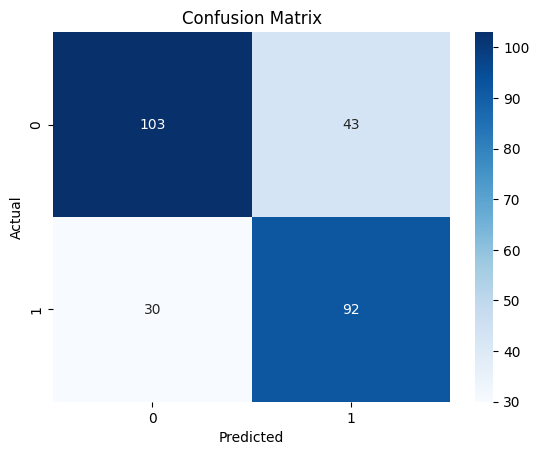

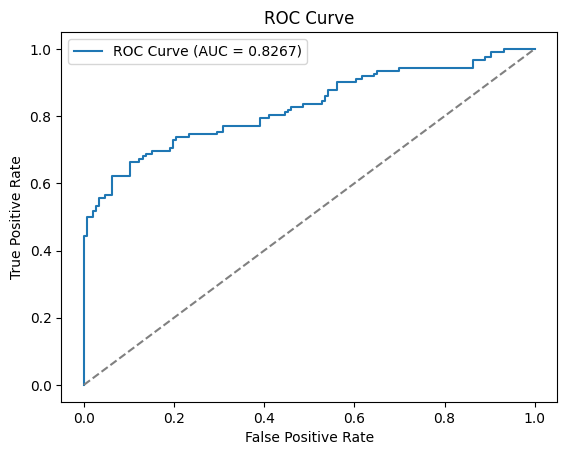

In [9]:
from sklearn.metrics import classification_report, roc_auc_score, confusion_matrix, roc_curve
import matplotlib.pyplot as plt
import seaborn as sns

# Entrenar el mejor modelo
best_model = grid_searches['Logistic Regression'].best_estimator_
best_model.fit(X_train, y_train)

# Predicciones
y_pred = best_model.predict(X_test)
y_pred_proba = best_model.predict_proba(X_test)[:, 1]

# Métricas
print(classification_report(y_test, y_pred))
print(f"ROC-AUC: {roc_auc_score(y_test, y_pred_proba):.4f}")

# Matriz de confusión
cm = confusion_matrix(y_test, y_pred)
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues')
plt.title('Confusion Matrix')
plt.xlabel('Predicted')
plt.ylabel('Actual')
plt.show()

# Curva ROC
fpr, tpr, thresholds = roc_curve(y_test, y_pred_proba)
plt.plot(fpr, tpr, label=f'ROC Curve (AUC = {roc_auc_score(y_test, y_pred_proba):.4f})')
plt.plot([0, 1], [0, 1], linestyle='--', color='grey')
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('ROC Curve')
plt.legend()
plt.show()
